In [ ]:
pip install torch torchvision transformers h5py numpy scikit-learn tqdm pillow

In [ ]:
import os
import random
from dataclasses import dataclass
from pathlib import Path
from typing import Dict, List, Optional, Tuple

import h5py
import numpy as np
from PIL import Image
from tqdm import tqdm

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader

from sklearn.metrics import accuracy_score, f1_score, roc_auc_score
from transformers import AutoImageProcessor, AutoModel

DATA_ROOT = Path.home() / "Downloads" / "grasp"
BACKBONE = "facebook/convnext-tiny-224"

EPOCHS = 3
BATCH_SIZE = 8
LR = 2e-4
NUM_WORKERS = 0
SEED = 42

USE_FORCES = False
FREEZE_BACKBONE = True          # faster, less overfit
FRAME_STRIDE = 5                # use every 5th frame; keep 1 for full frames

TRAIN_FRAC = 0.8
VAL_FRAC = 0.1

OUT_DIR = Path.home() / "Downloads" / "runs_grasp"

LOG_EVERY = 25                  # print avg loss every N train steps
EVAL_EVERY = 200                # quick validation every N steps
QUICK_EVAL_MAX_BATCHES = 50     # limit val batches for quick eval

def set_seed(seed: int) -> None:
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)


def read_attr_seq_100(h5_path: Path) -> np.ndarray:
    with h5py.File(h5_path, "r") as f:
        g = f["data"]
        return np.array([g.attrs[f"i{t}"] for t in range(100)])


def read_normal_force_100x2(h5_path: Path) -> np.ndarray:
    with h5py.File(h5_path, "r") as f:
        d = f["data"]
        out = np.zeros((100, 2), dtype=np.float32)
        for t in range(100):
            gt = d[f"i{t}"]
            out[t, 0] = float(gt.attrs["i0"])
            out[t, 1] = float(gt.attrs["i1"])
        return out


def read_tactile_frame(h5_path: Path, t: int) -> np.ndarray:
    with h5py.File(h5_path, "r") as f:
        d = f["data"]
        return d[f"i{t}"][()]

def list_trial_ids(data_root: Path) -> List[str]:
    trial_ids = []
    for p in sorted(data_root.iterdir()):
        if p.is_dir() and p.name.isdigit():
            tid = p.name
            req = [
                p / f"{tid}_tactileColorL.h5",
                p / f"{tid}_tactileColorR.h5",
                p / f"{tid}_label.h5",
                p / f"{tid}_gripForce.h5",
                p / f"{tid}_normalForce.h5",
            ]
            if all(x.exists() for x in req):
                trial_ids.append(tid)
    return trial_ids


def trial_final_label(data_root: Path, tid: str) -> int:
    folder = data_root / tid
    y = read_attr_seq_100(folder / f"{tid}_label.h5").astype(int)
    return int(y[-1])


def stratified_split_trials(
    trial_ids: List[str],
    data_root: Path,
    seed: int,
    train_frac: float,
    val_frac: float,
) -> Tuple[List[str], List[str], List[str]]:
    """
    We stratify by label at the final frame (t=99) to see if both classes appear
    in val/test splits. This does not change the training task (still frame-level).
    """
    rng = np.random.RandomState(seed)
    zeros, ones = [], []

    for tid in trial_ids:
        y = trial_final_label(data_root, tid)
        (ones if y == 1 else zeros).append(tid)

    rng.shuffle(zeros)
    rng.shuffle(ones)

    def split_class(ids: List[str]):
        n = len(ids)
        n_train = int(round(n * train_frac))
        n_val = int(round(n * val_frac))
        train = ids[:n_train]
        val = ids[n_train:n_train + n_val]
        test = ids[n_train + n_val:]
        return train, val, test

    z_tr, z_va, z_te = split_class(zeros)
    o_tr, o_va, o_te = split_class(ones)

    train_ids = z_tr + o_tr
    val_ids = z_va + o_va
    test_ids = z_te + o_te

    rng.shuffle(train_ids)
    rng.shuffle(val_ids)
    rng.shuffle(test_ids)

    if len(val_ids) == 0 and len(train_ids) > 1:
        val_ids = [train_ids.pop()]
    if len(test_ids) == 0 and len(train_ids) > 1:
        test_ids = [train_ids.pop()]

    return train_ids, val_ids, test_ids


def print_split_balance(data_root: Path, name: str, tids: List[str]):
    finals = np.array([trial_final_label(data_root, tid) for tid in tids])
    c0 = int((finals == 0).sum())
    c1 = int((finals == 1).sum())
    print(f"{name} trials: {len(tids)}  final-label counts (for stratify only): 0->{c0}, 1->{c1}")


@dataclass
class ForceStats:
    mean: np.ndarray
    std: np.ndarray


def compute_force_stats(data_root: Path, trial_ids: List[str]) -> ForceStats:
    all_rows = []
    for tid in tqdm(trial_ids, desc="Compute force stats"):
        folder = data_root / tid
        grip = read_attr_seq_100(folder / f"{tid}_gripForce.h5").astype(np.float32)
        normal = read_normal_force_100x2(folder / f"{tid}_normalForce.h5").astype(np.float32)
        rows = np.concatenate([grip[:, None], normal], axis=1)
        all_rows.append(rows)

    X = np.concatenate(all_rows, axis=0)
    mean = X.mean(axis=0)
    std = X.std(axis=0)
    std = np.where(std < 1e-6, 1.0, std)
    return ForceStats(mean=mean, std=std)


class GraspFrameDataset(Dataset):
    def __init__(
        self,
        data_root: Path,
        trial_ids: List[str],
        processor: AutoImageProcessor,
        use_forces: bool,
        force_stats: Optional[ForceStats] = None,
        frame_stride: int = 1,
    ):
        self.data_root = data_root
        self.trial_ids = trial_ids
        self.processor = processor
        self.use_forces = use_forces
        self.force_stats = force_stats

        stride = max(1, int(frame_stride))
        frames = set(range(0, 100, stride))
        frames.add(99)  # true final frame exists even if stride skips it
        self.frames = sorted(frames)

        self.index = [(i, t) for i in range(len(trial_ids)) for t in self.frames]

    def __len__(self) -> int:
        return len(self.index)

    def __getitem__(self, idx: int) -> Dict[str, torch.Tensor]:
        trial_idx, t = self.index[idx]
        tid = self.trial_ids[trial_idx]
        folder = self.data_root / tid

        L = read_tactile_frame(folder / f"{tid}_tactileColorL.h5", t)
        R = read_tactile_frame(folder / f"{tid}_tactileColorR.h5", t)

        imgL = Image.fromarray(L)
        imgR = Image.fromarray(R)

        procL = self.processor(images=imgL, return_tensors="pt")
        procR = self.processor(images=imgR, return_tensors="pt")
        pixelL = procL["pixel_values"].squeeze(0)
        pixelR = procR["pixel_values"].squeeze(0)

        label_seq = read_attr_seq_100(folder / f"{tid}_label.h5").astype(np.int64)
        y = int(label_seq[t])

        out = {
            "pixelL": pixelL,
            "pixelR": pixelR,
            "y": torch.tensor(y, dtype=torch.float32),
        }

        if self.use_forces:
            grip = float(read_attr_seq_100(folder / f"{tid}_gripForce.h5")[t])
            normal = read_normal_force_100x2(folder / f"{tid}_normalForce.h5")[t]
            feats = np.array([grip, float(normal[0]), float(normal[1])], dtype=np.float32)
            if self.force_stats is not None:
                feats = (feats - self.force_stats.mean) / self.force_stats.std
            out["force"] = torch.tensor(feats, dtype=torch.float32)

        return out


def collate_fn(batch: List[Dict[str, torch.Tensor]]) -> Dict[str, torch.Tensor]:
    out = {
        "pixelL": torch.stack([b["pixelL"] for b in batch], dim=0),
        "pixelR": torch.stack([b["pixelR"] for b in batch], dim=0),
        "y": torch.stack([b["y"] for b in batch], dim=0),
    }
    if "force" in batch[0]:
        out["force"] = torch.stack([b["force"] for b in batch], dim=0)
    return out


def pooled_embedding(outputs: object) -> torch.Tensor:
    if hasattr(outputs, "pooler_output") and outputs.pooler_output is not None:
        return outputs.pooler_output
    if hasattr(outputs, "last_hidden_state") and outputs.last_hidden_state is not None:
        x = outputs.last_hidden_state
        if x.dim() == 3:
            return x.mean(dim=1)
        if x.dim() == 4:
            return x.mean(dim=(1, 2))
    raise RuntimeError("Could not extract pooled embedding.")


class GraspStabilityNet(nn.Module):
    def __init__(
        self,
        backbone_name: str,
        use_forces: bool,
        force_dim: int = 3,
        mlp_hidden: int = 256,
        dropout: float = 0.1,
        freeze_backbone: bool = False,
    ):
        super().__init__()
        self.use_forces = use_forces
        self.backbone = AutoModel.from_pretrained(backbone_name)

        hidden = getattr(self.backbone.config, "hidden_size", None)
        if hidden is None:
            hs = getattr(self.backbone.config, "hidden_sizes", None)
            if hs is None:
                raise RuntimeError("Could not infer backbone dim.")
            hidden = hs[-1]

        in_dim = 2 * hidden + (force_dim if use_forces else 0)
        self.head = nn.Sequential(
            nn.Linear(in_dim, mlp_hidden),
            nn.ReLU(),
            nn.Dropout(dropout),
            nn.Linear(mlp_hidden, 1),
        )

        if freeze_backbone:
            for p in self.backbone.parameters():
                p.requires_grad = False

    def forward(self, pixelL: torch.Tensor, pixelR: torch.Tensor, force: Optional[torch.Tensor] = None) -> torch.Tensor:
        outL = self.backbone(pixel_values=pixelL)
        outR = self.backbone(pixel_values=pixelR)
        embL = pooled_embedding(outL)
        embR = pooled_embedding(outR)

        x = torch.cat([embL, embR], dim=1)
        if self.use_forces and force is not None:
            x = torch.cat([x, force], dim=1)

        return self.head(x).squeeze(1)


def sigmoid_np(x: np.ndarray) -> np.ndarray:
    return 1.0 / (1.0 + np.exp(-x))


def wilson_ci(k: int, n: int, z: float = 1.96) -> Tuple[float, float]:
    """
    Wilson score interval for a binomial proportion (accuracy).
    """
    if n == 0:
        return (float("nan"), float("nan"))
    p = k / n
    denom = 1 + (z**2) / n
    center = (p + (z**2) / (2*n)) / denom
    half = (z * np.sqrt((p*(1-p) + (z**2) / (4*n)) / n)) / denom
    return (max(0.0, center - half), min(1.0, center + half))


@torch.no_grad()
def evaluate_frame_level(
    model: nn.Module,
    loader: DataLoader,
    device: torch.device,
    max_batches: Optional[int] = None
) -> Dict[str, float]:
    model.eval()
    all_logits, all_y = [], []

    for bi, batch in enumerate(tqdm(loader, desc="Eval", leave=False)):
        if max_batches is not None and bi >= max_batches:
            break

        pixelL = batch["pixelL"].to(device)
        pixelR = batch["pixelR"].to(device)
        y = batch["y"].to(device)

        if "force" in batch:
            logits = model(pixelL, pixelR, force=batch["force"].to(device))
        else:
            logits = model(pixelL, pixelR, force=None)

        all_logits.append(logits.detach().cpu().numpy())
        all_y.append(y.detach().cpu().numpy())

    logits = np.concatenate(all_logits, axis=0)
    y = np.concatenate(all_y, axis=0).astype(int)

    probs = sigmoid_np(logits)
    pred = (probs > 0.5).astype(int)

    acc = float(accuracy_score(y, pred))
    f1 = float(f1_score(y, pred, zero_division=0))
    try:
        auc = float(roc_auc_score(y, probs))
    except Exception:
        auc = float("nan")

    # Confidence interval for accuracy
    k = int((pred == y).sum())
    n = int(len(y))
    lo, hi = wilson_ci(k, n)

    return {
        "frame_acc": acc,
        "frame_f1": f1,
        "frame_auc": auc,
        "frame_acc_ci95_lo": float(lo),
        "frame_acc_ci95_hi": float(hi),
        "num_frames_eval": n,
    }


def frame_class_balance(data_root: Path, tids: List[str]) -> Tuple[int, int, float]:
    pos = 0
    total = 0
    for tid in tids:
        y = read_attr_seq_100(data_root / tid / f"{tid}_label.h5").astype(int)
        pos += int(y.sum())
        total += len(y)
    neg = total - pos
    rate = pos / total if total > 0 else float("nan")
    return neg, pos, rate


def train_one_epoch_live(
    model: nn.Module,
    loader: DataLoader,
    optimizer: torch.optim.Optimizer,
    device: torch.device,
    log_every: int = 25,
    eval_every: Optional[int] = None,
    val_loader: Optional[DataLoader] = None
) -> float:
    model.train()
    losses = []
    running = 0.0

    for step, batch in enumerate(tqdm(loader, desc="Train", leave=False), start=1):
        pixelL = batch["pixelL"].to(device)
        pixelR = batch["pixelR"].to(device)
        y = batch["y"].to(device)

        optimizer.zero_grad(set_to_none=True)

        if "force" in batch:
            logits = model(pixelL, pixelR, force=batch["force"].to(device))
        else:
            logits = model(pixelL, pixelR, force=None)

        loss = F.binary_cross_entropy_with_logits(logits, y)
        loss.backward()
        optimizer.step()

        l = float(loss.detach().cpu().item())
        losses.append(l)
        running += l

        if step % log_every == 0:
            avg = running / log_every
            tqdm.write(f"  step {step}/{len(loader)}  avg_loss({log_every})={avg:.4f}")
            running = 0.0

        if eval_every is not None and val_loader is not None and step % eval_every == 0:
            tqdm.write("  quick-eval on val (frame-level, limited batches)...")
            m = evaluate_frame_level(model, val_loader, device, max_batches=QUICK_EVAL_MAX_BATCHES)
            tqdm.write(f"  quick val frame_f1={m['frame_f1']:.4f} frame_acc={m['frame_acc']:.4f}")

    return float(np.mean(losses)) if losses else float("nan")


def pick_device():
    if torch.cuda.is_available():
        return torch.device("cuda")
    if hasattr(torch.backends, "mps") and torch.backends.mps.is_available():
        return torch.device("mps")
    return torch.device("cpu")


def run_training():
    set_seed(SEED)
    data_root = Path(DATA_ROOT).expanduser().resolve()
    OUT_DIR.mkdir(parents=True, exist_ok=True)

    device = pick_device()
    print("Device:", device)
    print("Data root:", data_root)

    trial_ids = list_trial_ids(data_root)
    if len(trial_ids) == 0:
        raise RuntimeError(f"No valid trial folders found under {data_root}")
    print(f"Found {len(trial_ids)} trials.")

    train_ids, val_ids, test_ids = stratified_split_trials(trial_ids, data_root, seed=SEED, train_frac=TRAIN_FRAC, val_frac=VAL_FRAC)

    print_split_balance(data_root, "TRAIN", train_ids)
    print_split_balance(data_root, "VAL  ", val_ids)
    print_split_balance(data_root, "TEST ", test_ids)

    tr_neg, tr_pos, tr_rate = frame_class_balance(data_root, train_ids)
    va_neg, va_pos, va_rate = frame_class_balance(data_root, val_ids)
    print(f"Frame label balance (train): pos={tr_pos} neg={tr_neg} pos_rate={tr_rate:.3f}")
    print(f"Frame label balance (val):   pos={va_pos} neg={va_neg} pos_rate={va_rate:.3f}")

    print("\nNOTE:")
    print(f"- Validation has {len(val_ids)} trials and test has {len(test_ids)} trials.")
    print("- Trial counts are small, so any trial-aggregated metrics can have high variance.")
    print("- This notebook therefore reports FRAME-LEVEL metrics (acc/F1/AUC) as the primary results.\n")

    processor = AutoImageProcessor.from_pretrained(BACKBONE)

    force_stats = None
    if USE_FORCES:
        force_stats = compute_force_stats(data_root, train_ids)
        print("Force mean:", force_stats.mean)
        print("Force std :", force_stats.std)

    ds_train = GraspFrameDataset(data_root, train_ids, processor, use_forces=USE_FORCES, force_stats=force_stats, frame_stride=FRAME_STRIDE)
    ds_val   = GraspFrameDataset(data_root, val_ids, processor, use_forces=USE_FORCES, force_stats=force_stats, frame_stride=FRAME_STRIDE)
    ds_test  = GraspFrameDataset(data_root, test_ids, processor, use_forces=USE_FORCES, force_stats=force_stats, frame_stride=FRAME_STRIDE)

    print(f"Train samples: {len(ds_train)}  Val samples: {len(ds_val)}  Test samples: {len(ds_test)}  (stride={FRAME_STRIDE}, includes t=99)")

    pin = (device.type == "cuda")

    dl_train = DataLoader(ds_train, batch_size=BATCH_SIZE, shuffle=True, num_workers=NUM_WORKERS, collate_fn=collate_fn, pin_memory=pin)
    dl_val   = DataLoader(ds_val, batch_size=BATCH_SIZE, shuffle=False, num_workers=NUM_WORKERS, collate_fn=collate_fn, pin_memory=pin)
    dl_test  = DataLoader(ds_test, batch_size=BATCH_SIZE, shuffle=False, num_workers=NUM_WORKERS, collate_fn=collate_fn, pin_memory=pin)

    model = GraspStabilityNet(BACKBONE, use_forces=USE_FORCES, freeze_backbone=FREEZE_BACKBONE).to(device)
    optimizer = torch.optim.AdamW([p for p in model.parameters() if p.requires_grad], lr=LR)

    best_val_f1 = -1.0
    best_path = OUT_DIR / "best_model.pt"

    for epoch in range(1, EPOCHS + 1):
        print(f"\nEpoch {epoch}/{EPOCHS}")
        train_loss = train_one_epoch_live(
            model, dl_train, optimizer, device,
            log_every=LOG_EVERY,
            eval_every=EVAL_EVERY,
            val_loader=dl_val
        )

        val_metrics = evaluate_frame_level(model, dl_val, device, max_batches=None)

        print(f"  train_loss: {train_loss:.4f}")
        print(f"  val frame_acc: {val_metrics['frame_acc']:.4f}  frame_f1: {val_metrics['frame_f1']:.4f}  frame_auc: {val_metrics['frame_auc']:.4f}")
        print(f"  val frame_acc 95% CI: [{val_metrics['frame_acc_ci95_lo']:.4f}, {val_metrics['frame_acc_ci95_hi']:.4f}]  (n_frames={val_metrics['num_frames_eval']})")

        if val_metrics["frame_f1"] > best_val_f1:
            best_val_f1 = val_metrics["frame_f1"]
            torch.save(
                {
                    "model_state": model.state_dict(),
                    "epoch": epoch,
                    "val_metrics": val_metrics,
                    "config": {
                        "BACKBONE": BACKBONE,
                        "USE_FORCES": USE_FORCES,
                        "FREEZE_BACKBONE": FREEZE_BACKBONE,
                        "FRAME_STRIDE": FRAME_STRIDE,
                        "INCLUDES_T99": True,
                    },
                },
                best_path
            )
            print(f"  Saved new best model to {best_path}")

    ckpt = torch.load(best_path, map_location=device)
    model.load_state_dict(ckpt["model_state"])
    test_metrics = evaluate_frame_level(model, dl_test, device, max_batches=None)

    print("\n=== TEST METRICS (best checkpoint, frame-level) ===")
    print(f"test frame_acc: {test_metrics['frame_acc']:.4f}  frame_f1: {test_metrics['frame_f1']:.4f}  frame_auc: {test_metrics['frame_auc']:.4f}")
    print(f"test frame_acc 95% CI: [{test_metrics['frame_acc_ci95_lo']:.4f}, {test_metrics['frame_acc_ci95_hi']:.4f}]  (n_frames={test_metrics['num_frames_eval']})")

    with open(OUT_DIR / "metrics.txt", "w") as f:
        f.write("Best val metrics:\n")
        for k, v in ckpt["val_metrics"].items():
            f.write(f"{k}: {v}\n")
        f.write("\nTest metrics:\n")
        for k, v in test_metrics.items():
            f.write(f"{k}: {v}\n")

    print(f"\nSaved metrics to {OUT_DIR / 'metrics.txt'}")
    print(f"Saved best model to {best_path}")
    return test_metrics

test_metrics = run_training()
test_metrics

Device: mps
Data root: /Users/nisargamv/Downloads/grasp
Found 101 trials.
TRAIN trials: 80  final-label counts (for stratify only): 0->50, 1->30
VAL   trials: 10  final-label counts (for stratify only): 0->6, 1->4
TEST  trials: 11  final-label counts (for stratify only): 0->7, 1->4
Frame label balance (train): pos=3117 neg=4883 pos_rate=0.390
Frame label balance (val):   pos=385 neg=615 pos_rate=0.385

NOTE:
- Validation has 10 trials and test has 11 trials.
- Trial counts are small, so any trial-aggregated metrics can have high variance.
- This notebook therefore reports FRAME-LEVEL metrics (acc/F1/AUC) as the primary results.



'(ReadTimeoutError("HTTPSConnectionPool(host='huggingface.co', port=443): Read timed out. (read timeout=10)"), '(Request ID: fb3a2ac7-83ab-4603-a057-065373cdc76a)')' thrown while requesting HEAD https://huggingface.co/facebook/convnext-tiny-224/resolve/main/preprocessor_config.json
Retrying in 1s [Retry 1/5].


Train samples: 1680  Val samples: 210  Test samples: 231  (stride=5, includes t=99)

Epoch 1/3


Train:  12%|█▏        | 25/210 [00:15<01:26,  2.15it/s]

  step 25/210  avg_loss(25)=0.5623


Train:  24%|██▍       | 50/210 [00:28<01:30,  1.77it/s]

  step 50/210  avg_loss(25)=0.4058


Train:  36%|███▌      | 75/210 [00:40<01:06,  2.02it/s]

  step 75/210  avg_loss(25)=0.3095


Train:  48%|████▊     | 100/210 [00:51<00:47,  2.30it/s]

  step 100/210  avg_loss(25)=0.2730


Train:  60%|█████▉    | 125/210 [01:03<00:43,  1.94it/s]

  step 125/210  avg_loss(25)=0.2681


Train:  71%|███████▏  | 150/210 [01:15<00:26,  2.26it/s]

  step 150/210  avg_loss(25)=0.2235


Train:  83%|████████▎ | 175/210 [01:28<00:19,  1.78it/s]

  step 175/210  avg_loss(25)=0.2533


Train:  95%|█████████▍| 199/210 [01:43<00:05,  2.00it/s]

  step 200/210  avg_loss(25)=0.2504
  quick-eval on val (frame-level, limited batches)...


Train:  95%|█████████▌| 200/210 [01:55<00:42,  4.26s/it]

  quick val frame_f1=0.9153 frame_acc=0.9286


  train_loss: 0.3118
  val frame_acc: 0.9333  frame_f1: 0.9222  frame_auc: 0.9722
  val frame_acc 95% CI: [0.8912, 0.9599]  (n_frames=210)
  Saved new best model to /Users/nisargamv/Downloads/runs_grasp/best_model.pt

Epoch 2/3


Train:  12%|█▏        | 25/210 [00:11<01:27,  2.13it/s]

  step 25/210  avg_loss(25)=0.1768


Train:  24%|██▍       | 50/210 [00:22<01:14,  2.14it/s]

  step 50/210  avg_loss(25)=0.1849


Train:  36%|███▌      | 75/210 [00:34<00:58,  2.31it/s]

  step 75/210  avg_loss(25)=0.1833


Train:  48%|████▊     | 100/210 [00:44<00:46,  2.38it/s]

  step 100/210  avg_loss(25)=0.2486


Train:  60%|█████▉    | 125/210 [00:55<00:37,  2.26it/s]

  step 125/210  avg_loss(25)=0.1965


Train:  71%|███████▏  | 150/210 [01:06<00:31,  1.93it/s]

  step 150/210  avg_loss(25)=0.1865


Train:  83%|████████▎ | 175/210 [01:17<00:14,  2.37it/s]

  step 175/210  avg_loss(25)=0.1350


Train:  95%|█████████▍| 199/210 [01:28<00:04,  2.33it/s]

  step 200/210  avg_loss(25)=0.2207
  quick-eval on val (frame-level, limited batches)...


Train:  95%|█████████▌| 200/210 [01:42<00:46,  4.68s/it]

  quick val frame_f1=0.9257 frame_acc=0.9381


  train_loss: 0.1898
  val frame_acc: 0.9429  frame_f1: 0.9333  frame_auc: 0.9844
  val frame_acc 95% CI: [0.9028, 0.9670]  (n_frames=210)
  Saved new best model to /Users/nisargamv/Downloads/runs_grasp/best_model.pt

Epoch 3/3


Train:  12%|█▏        | 25/210 [00:13<01:44,  1.77it/s]

  step 25/210  avg_loss(25)=0.1294


Train:  24%|██▍       | 50/210 [00:25<01:14,  2.14it/s]

  step 50/210  avg_loss(25)=0.1375


Train:  36%|███▌      | 75/210 [00:36<00:59,  2.25it/s]

  step 75/210  avg_loss(25)=0.1351


Train:  48%|████▊     | 100/210 [00:48<01:05,  1.68it/s]

  step 100/210  avg_loss(25)=0.2223


Train:  60%|█████▉    | 125/210 [01:00<00:38,  2.21it/s]

  step 125/210  avg_loss(25)=0.2103


Train:  71%|███████▏  | 150/210 [01:12<00:27,  2.19it/s]

  step 150/210  avg_loss(25)=0.1552


Train:  83%|████████▎ | 175/210 [01:23<00:15,  2.26it/s]

  step 175/210  avg_loss(25)=0.1238


Train:  95%|█████████▍| 199/210 [01:34<00:04,  2.28it/s]

  step 200/210  avg_loss(25)=0.1491
  quick-eval on val (frame-level, limited batches)...


Train:  95%|█████████▌| 200/210 [01:46<00:40,  4.02s/it]

  quick val frame_f1=0.9195 frame_acc=0.9333


  train_loss: 0.1565
  val frame_acc: 0.9381  frame_f1: 0.9290  frame_auc: 0.9886
  val frame_acc 95% CI: [0.8970, 0.9635]  (n_frames=210)



=== TEST METRICS (best checkpoint, frame-level) ===
test frame_acc: 0.9134  frame_f1: 0.8901  frame_auc: 0.9715
test frame_acc 95% CI: [0.8701, 0.9433]  (n_frames=231)

Saved metrics to /Users/nisargamv/Downloads/runs_grasp/metrics.txt
Saved best model to /Users/nisargamv/Downloads/runs_grasp/best_model.pt


{'frame_acc': 0.9134199134199135,
 'frame_f1': 0.8901098901098901,
 'frame_auc': 0.9715070643642072,
 'frame_acc_ci95_lo': 0.8700591031643362,
 'frame_acc_ci95_hi': 0.9432550626393376,
 'num_frames_eval': 231}

In [ ]:
best_path = OUT_DIR / "best_model.pt"
print("Using best checkpoint:", best_path)

device = torch.device("cuda" if torch.cuda.is_available() else ("mps" if hasattr(torch.backends, "mps") and torch.backends.mps.is_available() else "cpu"))
print("Device:", device)

# Reload processor & model 
processor = AutoImageProcessor.from_pretrained(BACKBONE)

# Rebuild splits
trial_ids = list_trial_ids(DATA_ROOT)
train_ids, val_ids, test_ids = stratified_split_trials(trial_ids, DATA_ROOT, seed=SEED, train_frac=TRAIN_FRAC, val_frac=VAL_FRAC)
print("Trials:", len(trial_ids), "Train/Val/Test:", len(train_ids), len(val_ids), len(test_ids))

# Rebuild dataset+loader
ds_test = GraspFrameDataset(DATA_ROOT, test_ids, processor, use_forces=USE_FORCES, force_stats=None, frame_stride=FRAME_STRIDE)
dl_test = DataLoader(ds_test, batch_size=BATCH_SIZE, shuffle=False, num_workers=NUM_WORKERS, collate_fn=collate_fn, pin_memory=False)

# Reload model weights
model = GraspStabilityNet(BACKBONE, use_forces=USE_FORCES, freeze_backbone=FREEZE_BACKBONE).to(device)
ckpt = torch.load(best_path, map_location=device)

# Support both checkpoint formats
state = ckpt["model_state"] if isinstance(ckpt, dict) and "model_state" in ckpt else ckpt
model.load_state_dict(state, strict=True)
model.eval()

print("Test frames in loader:", len(ds_test))

Using best checkpoint: /Users/nisargamv/Downloads/runs_grasp/best_model.pt
Device: mps
Trials: 101 Train/Val/Test: 80 10 11
Test frames in loader: 231


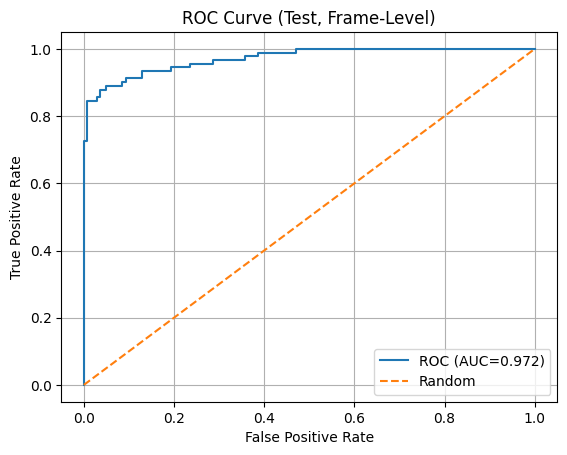

Saved: /Users/nisargamv/Downloads/runs_grasp/roc_curve.png


In [10]:
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc

@torch.no_grad()
def collect_probs_and_labels(model, loader, device):
    probs_all = []
    y_all = []
    for batch in loader:
        pixelL = batch["pixelL"].to(device)
        pixelR = batch["pixelR"].to(device)
        y = batch["y"].to(device)

        if "force" in batch:
            logits = model(pixelL, pixelR, force=batch["force"].to(device))
        else:
            logits = model(pixelL, pixelR, force=None)

        probs = torch.sigmoid(logits)
        probs_all.append(probs.detach().cpu().numpy())
        y_all.append(y.detach().cpu().numpy())

    probs = np.concatenate(probs_all, axis=0).astype(float)
    y = np.concatenate(y_all, axis=0).astype(int)
    return probs, y

probs_test, y_test = collect_probs_and_labels(model, dl_test, device)
fpr, tpr, _ = roc_curve(y_test, probs_test)
roc_auc = auc(fpr, tpr)

plt.figure()
plt.plot(fpr, tpr, label=f"ROC (AUC={roc_auc:.3f})")
plt.plot([0, 1], [0, 1], linestyle="--", label="Random")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve (Test, Frame-Level)")
plt.grid(True)
plt.legend()
roc_path = OUT_DIR / "roc_curve.png"
plt.savefig(roc_path, dpi=200, bbox_inches="tight")
plt.show()

print("Saved:", roc_path)

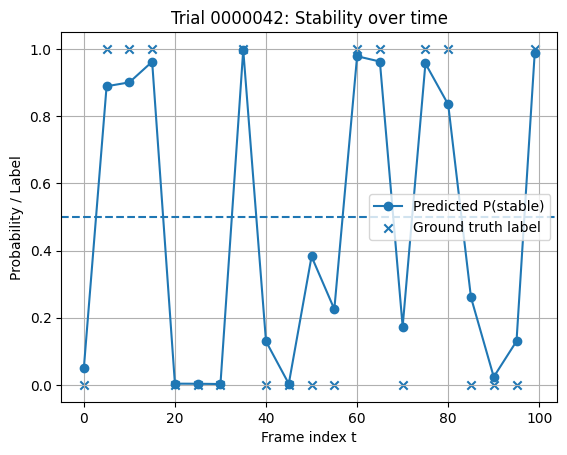

Saved: /Users/nisargamv/Downloads/runs_grasp/timeline_0000042.png
Timeline info:
frames: [0, 5, 10, 15, 20, 25, 30, 35, 40, 45, 50, 55, 60, 65, 70, 75, 80, 85, 90, 95, 99]
gt labels: [0, 1, 1, 1, 0, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 1, 1, 0, 0, 0, 1]
pred probs: [0.049, 0.889, 0.9, 0.962, 0.004, 0.003, 0.003, 0.997, 0.13, 0.003, 0.382, 0.225, 0.978, 0.962, 0.174, 0.957, 0.835, 0.261, 0.024, 0.13, 0.989]


In [ ]:
import matplotlib.pyplot as plt
from PIL import Image
import numpy as np
import torch

def get_frames_with_stride(stride=5):
    frames = set(range(0, 100, max(1, int(stride))))
    frames.add(99)
    return sorted(frames)

def load_trial_sequence(data_root: Path, tid: str, stride=5):
    frames = get_frames_with_stride(stride)
    folder = data_root / tid

    y_all = read_attr_seq_100(folder / f"{tid}_label.h5").astype(int)
    y = np.array([y_all[t] for t in frames], dtype=int)

    L_frames = []
    R_frames = []
    for t in frames:
        L = read_tactile_frame(folder / f"{tid}_tactileColorL.h5", t)
        R = read_tactile_frame(folder / f"{tid}_tactileColorR.h5", t)
        L_frames.append(Image.fromarray(L))
        R_frames.append(Image.fromarray(R))

    return frames, L_frames, R_frames, y

@torch.no_grad()
def predict_trial_probs(model, processor, L_frames, R_frames, device):
    model.eval()
    probs = []
    for imgL, imgR in zip(L_frames, R_frames):
        pL = processor(images=imgL, return_tensors="pt")["pixel_values"].to(device)
        pR = processor(images=imgR, return_tensors="pt")["pixel_values"].to(device)
        logit = model(pL, pR, force=None)
        probs.append(torch.sigmoid(logit).item())
    return np.array(probs, dtype=float)

def plot_trial_timeline(frames, probs, y, tid, out_path: Path):
    x = np.array(frames)

    plt.figure()
    plt.plot(x, probs, marker="o", label="Predicted P(stable)")
    plt.scatter(x, y, marker="x", label="Ground truth label")
    plt.axhline(0.5, linestyle="--")
    plt.xlabel("Frame index t")
    plt.ylabel("Probability / Label")
    plt.title(f"Trial {tid}: Stability over time")
    plt.ylim(-0.05, 1.05)
    plt.grid(True)
    plt.legend()
    plt.savefig(out_path, dpi=200, bbox_inches="tight")
    plt.show()

example_tid = test_ids[0]
frames, L_frames, R_frames, y_seq = load_trial_sequence(DATA_ROOT, example_tid, stride=FRAME_STRIDE)
probs_seq = predict_trial_probs(model, processor, L_frames, R_frames, device)

timeline_path = OUT_DIR / f"timeline_{example_tid}.png"
plot_trial_timeline(frames, probs_seq, y_seq, example_tid, timeline_path)
print("Saved:", timeline_path)

print("Timeline info:")
print("frames:", frames)
print("gt labels:", y_seq.tolist())
print("pred probs:", [round(x, 3) for x in probs_seq.tolist()])

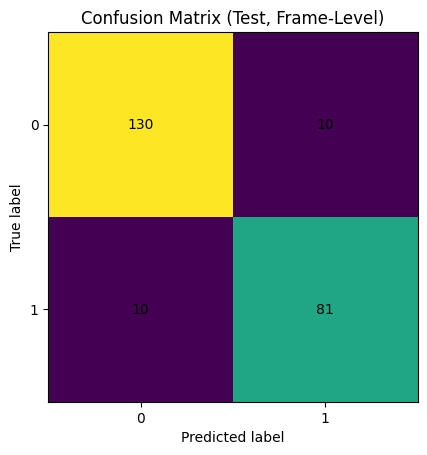

Saved: /Users/nisargamv/Downloads/runs_grasp/confusion_matrix_frame.png
Confusion matrix:
 [[130  10]
 [ 10  81]]


In [12]:
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix

y_pred = (probs_test > 0.5).astype(int)
cm = confusion_matrix(y_test, y_pred, labels=[0, 1])

plt.figure()
plt.imshow(cm, interpolation="nearest")
plt.title("Confusion Matrix (Test, Frame-Level)")
plt.xlabel("Predicted label")
plt.ylabel("True label")
plt.xticks([0, 1], ["0", "1"])
plt.yticks([0, 1], ["0", "1"])

for i in range(2):
    for j in range(2):
        plt.text(j, i, str(cm[i, j]), ha="center", va="center")

cm_path = OUT_DIR / "confusion_matrix_frame.png"
plt.savefig(cm_path, dpi=200, bbox_inches="tight")
plt.show()

print("Saved:", cm_path)
print("Confusion matrix:\n", cm)